# <center> cs231. Assignment 1.

Goal is to build neural network with linear layers to work on CIFAR-10 dataset. There is my own implementation, which I will double check with PyTorch.

## Importing libs

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt

import sys
import os
import glob
import pickle

# ================================================

if not '..' in sys.path:
    sys.path = ['..'] + sys.path
    
from _cs231n.neural_nets import layers, models
from _cs231n.metrics import accuracy

# ================================================

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from _cs231n.torch_utils import predict_torch, train_torch

# ================================================

PATH_TO_DATA = '../data/cifar-10-batches-py'

## Loading & visualizing dataset

Dataset has been previously downloaded from [here](https://www.cs.toronto.edu/~kriz/cifar.html). There is a script `get_data.sh` in `assignment1` folder for this. Dataset is already split into train and test.

In [2]:
X_train0 = []
y_train0 = []

for fname in glob.glob(os.path.join(PATH_TO_DATA, 'data_batch_*')):
    with open(fname, 'rb') as fh:
        batch = pickle.load(fh, encoding='bytes')
        
    X_train0.append(batch[b'data'])
    y_train0 += batch[b'labels']
    
X_train0 = np.vstack(X_train0).astype(np.float64)/255
y_train0 = np.array(y_train0)
print('Training data shape: {0}x{1}'.format(*X_train0.shape))

# ================================================

with open(os.path.join(PATH_TO_DATA, 'test_batch'), 'rb') as fh:
    batch = pickle.load(fh, encoding='bytes')
    
    X_test0 = batch[b'data'].astype(np.float64)/255
    y_test0 = batch[b'labels']
    
print('Test data shape: {0}x{1}'.format(*X_test0.shape))

# ================================================

with open(os.path.join(PATH_TO_DATA, 'batches.meta'), 'rb') as fh:
    categories_meta = pickle.load(fh, encoding='bytes')
    categories = [x.decode('UTF-8') for x in categories_meta[b'label_names']]

Training data shape: 50000x3072
Test data shape: 10000x3072


Let's visualize dataset to see what we're dealing with. There are 10 categories of images, we will display several pics from each category.

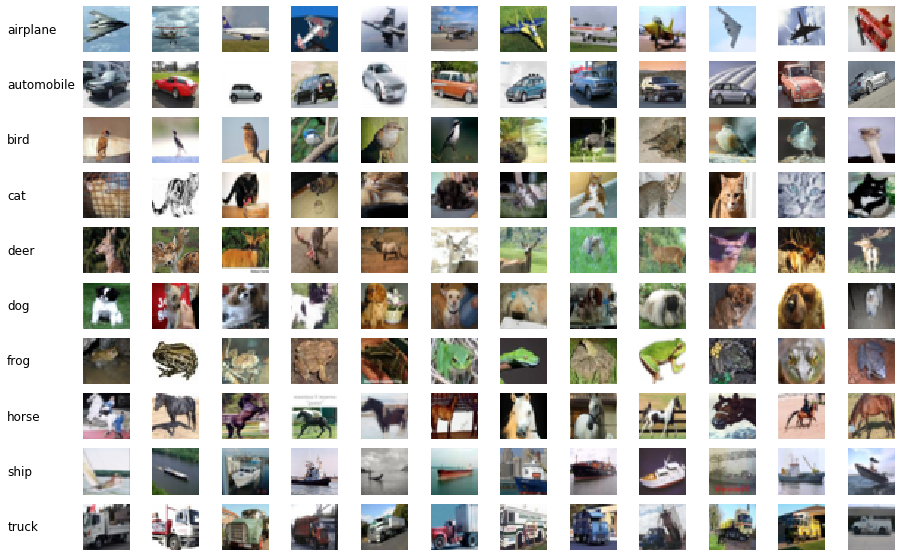

In [3]:
n_imgs = 12
labels = np.unique(y_train0)

fig0, axs = plt.subplots(nrows=len(labels), ncols=n_imgs + 1, figsize=(16, len(labels)))
for (xlabel, xcat, xaxs) in zip(labels, categories, axs):
    xaxs[0].text(0, 0.5, xcat, fontsize=12, va='center')
    xaxs[0].axis('off')
    idxs = np.random.choice(np.argwhere(y_train0 == xlabel).ravel(), n_imgs, replace=False)
    
    for (idx, xax) in zip(idxs, xaxs[1:]):
        xax.imshow(X_train0[idx].reshape(3, 32, 32).transpose(1, 2, 0))
        xax.set_aspect('equal')
        xax.axis('off')

Ok, due to low resolution some pics are pretty hard to get, even for human eye. Hope that neural net will do better than me.

As usual, we pick some data randomly from training set to serve as validation data.

In [4]:
val_part = 0.25
val_num = int(val_part*X_train0.shape[0])
tot_idxs = np.random.permutation(np.arange(X_train0.shape[0]))

val_idxs = tot_idxs[:val_num]
train_idxs = tot_idxs[val_num:]

## Model 1. Two-layered Network.

We start from a simple model - fully connected layer followed by ReLU non-linearity followed by another fully connected layer. Initialize the model and see what loss it gives without any training.

In [5]:
model1 = models.SequentialModel(
    layers=[
        layers.DenseLayer('FC1', features_in=3*32*32, features_out=256, include_bias=True, 
                          reg_coef=1e-2), 
        layers.ReLU('ReLU1'), 
        layers.DenseLayer('FC2', features_in=256, features_out=len(labels), include_bias=True, 
                          reg_coef=1e-2)
    ]
)

pred0, _, loss0, _ = model1.predict(X_train0, y_train0, batch_size=256)
print('Initial loss on training set : {0:.3f}'.format(loss0))
print('Initial accuracy on training set: {0:.2f}%'.format(100*accuracy(y_train0, pred0)))

Initial loss on training set : 2.395
Initial accuracy on training set: 8.16%


Hmmm... Expected loss is higher than theoretical one (which is $-\ln{\frac{1}{10}}\approx2.30$), though it is fairly close. Perhaps some unfortunate initialization.

### Overfitting on small dataset

Before starting training, let's make a sanity check and overfit the model to small dataset. First 50 objects, for example. Our model should be powerful enough to memorize them.


--------------------------------

Loss on training set : 0.382
Accuracy on training set: 100.00%


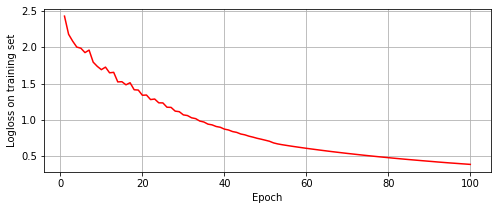

In [6]:
tiny_idx = 50
loss_tr, _, _ = models.train_SGD(model1, models.softmax_predict, 
    X_train0[:tiny_idx], y_train0[:tiny_idx], lr=2e-2, epochs=100, 
    lr_decrease_coef=0.8, lr_decrease_step=50, 
    batch_size=tiny_idx, show_progress=False, verbose=False)

pred1, _, loss1, _ = model1.predict(X_train0[:tiny_idx], y_train0[:tiny_idx], batch_size=tiny_idx)
print('Loss on training set : {0:.3f}'.format(loss1))
print('Accuracy on training set: {0:.2f}%'.format(100*accuracy(y_train0[:tiny_idx], pred1)))

fig0 = plt.figure(figsize=(8, 3))
plt.plot(np.arange(1, len(loss_tr) + 1), loss_tr, color='red')
plt.xlabel('Epoch')
plt.ylabel('Logloss on training set')
plt.gca().grid(True)

Indeed, we reached $100\%$ accuracy on small dataset. Let's proceed to training.

### Training

In [7]:
loss_tr, loss_val, acc_val = models.train_SGD(model1, models.softmax_predict, 
    X_train0[train_idxs], y_train0[train_idxs], X_train0[val_idxs], y_train0[val_idxs], 
    metric=accuracy, 
    lr=1e-2, epochs=25, 
    lr_decrease_coef=0.9, lr_decrease_step=5, momentum=0.5, 
    batch_size=128, show_progress=True, verbose=True)


--------------------------------

Epoch 1/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.9801167875325736
Validation loss: 1.8763274861607708
Validation metric: 0.33632

--------------------------------

Epoch 2/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.8510917454719917
Validation loss: 1.8195424249004852
Validation metric: 0.35832

--------------------------------

Epoch 3/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.8056999838623105
Validation loss: 1.79649091803309
Validation metric: 0.36648

--------------------------------

Epoch 4/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.7752429698450318
Validation loss: 1.7825482015510337
Validation metric: 0.37664

--------------------------------

Epoch 5/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.7538877924885463
Validation loss: 1.7646063922117479
Validation metric: 0.38768

--------------------------------

Epoch 6/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.736172019350318
Validation loss: 1.734489718259313
Validation metric: 0.398

--------------------------------

Epoch 7/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.7229277515088035
Validation loss: 1.7249919141746388
Validation metric: 0.40328

--------------------------------

Epoch 8/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.7111950235380347
Validation loss: 1.7196724740863778
Validation metric: 0.40736

--------------------------------

Epoch 9/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.7014643622358943
Validation loss: 1.7130561014898114
Validation metric: 0.40568

--------------------------------

Epoch 10/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.6927902988557237
Validation loss: 1.707528604697188
Validation metric: 0.40752

--------------------------------

Epoch 11/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.6841219678464527
Validation loss: 1.7039121161505877
Validation metric: 0.40424

--------------------------------

Epoch 12/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.6783666305636615
Validation loss: 1.6883635954641505
Validation metric: 0.41344

--------------------------------

Epoch 13/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.6717332507730525
Validation loss: 1.6809204414421965
Validation metric: 0.41632

--------------------------------

Epoch 14/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.666636036685892
Validation loss: 1.6786637657682837
Validation metric: 0.4216

--------------------------------

Epoch 15/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.6614413070570215
Validation loss: 1.6736690438801665
Validation metric: 0.41768

--------------------------------

Epoch 16/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 1.6561952268033169
Validation loss: 1.6653354589138203
Validation metric: 0.42432

--------------------------------

Epoch 17/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 1.6522334020151888
Validation loss: 1.6647689943817385
Validation metric: 0.42536

--------------------------------

Epoch 18/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 1.6489771241735875
Validation loss: 1.6629307204451136
Validation metric: 0.42376

--------------------------------

Epoch 19/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 1.645688758775476
Validation loss: 1.6641312501361774
Validation metric: 0.42648

--------------------------------

Epoch 20/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 1.6420134575779686
Validation loss: 1.659784373049966
Validation metric: 0.42568

--------------------------------

Epoch 21/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 1.6388336821055454
Validation loss: 1.6572079348700715
Validation metric: 0.42528

--------------------------------

Epoch 22/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 1.6359321135544178
Validation loss: 1.6534709732949155
Validation metric: 0.42704

--------------------------------

Epoch 23/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 1.6338238859967231
Validation loss: 1.656636428616085
Validation metric: 0.42256

--------------------------------

Epoch 24/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 1.6313609239922364
Validation loss: 1.6464782601510408
Validation metric: 0.42944

--------------------------------

Epoch 25/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 1.629193739065113
Validation loss: 1.650097771579466
Validation metric: 0.4276

--------------------------------



All right, we reached some good progress here - $42.8\%$ accuracy is much better than random guessing! Let's see the training history.

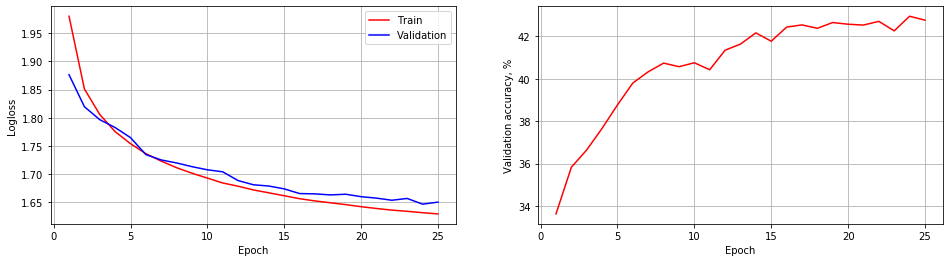

In [8]:
fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_tr, color='red', label='Train')
axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_val, color='blue', label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Logloss')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(np.arange(1, len(loss_tr) + 1), 100*np.array(acc_val), color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Validation accuracy, %')
axs[1].grid(True)

Looks decent - both losses are falling down, no sign of overfitting. Perhaps we can even train a bit more and get additional $1\%$ accuracy.

## Model 2. Two-layered network with batch normalization.

It is well known that batch normalization is a very good technique to speed up training. Let's see if it can help us here. We're inserting BatchNorm after first fully connected layer.

In [9]:
model2 = models.SequentialModel(
    layers=[
        layers.DenseLayer('FC1', features_in=3*32*32, features_out=256, include_bias=True, 
                          reg_coef=1e-2), 
        layers.BatchNorm('BN1'), 
        layers.ReLU('ReLU1'), 
        layers.DenseLayer('FC2', features_in=256, features_out=len(labels), include_bias=True, 
                          reg_coef=1e-2)
    ]
)

It might also be a good idea to normalize data as well. Remember that we're actually dealing with images here. Let's calculate mean and std for each of three color channels and use it for normalization.

In [10]:
X_mean = X_train0.reshape(X_train0.shape[0], 3, -1).mean(axis=(0, 2))
X_std = X_train0.reshape(X_train0.shape[0], 3, -1).std(axis=(0, 2))

X_train_norm = (X_train0 - np.repeat(X_mean, X_train0.shape[1]//3)[None, :])/\
    np.repeat(X_std, X_train0.shape[1]//3)[None, :]
X_test_norm = (X_test0 - np.repeat(X_mean, X_test0.shape[1]//3)[None, :])/\
    np.repeat(X_std, X_test0.shape[1]//3)[None, :]

Ok, checking how model has initialized.

In [11]:
pred0, _, loss0, _ = model2.predict(X_train_norm, y_train0)
print('Loss on training set : {0:.3f}'.format(loss0))
print('Accuracy on training set: {0:.2f}%'.format(100*accuracy(y_train0, pred0)))

Loss on training set : 2.652
Accuracy on training set: 10.46%


Boy, the loss again is higher than expected. Again unfortunate initialization?
Let's train the model.

In [12]:
loss_tr, loss_val, acc_val = models.train_SGD(model2, models.softmax_predict, 
    X_train_norm[train_idxs], y_train0[train_idxs], X_train_norm[val_idxs], y_train0[val_idxs], 
    metric=accuracy, 
    lr=1e-2, epochs=25, 
    lr_decrease_coef=0.9, lr_decrease_step=5, momentum=0.5, 
    batch_size=128, show_progress=True, verbose=True)


--------------------------------

Epoch 1/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.8572859962728574
Validation loss: 1.7099397261513396
Validation metric: 0.39944

--------------------------------

Epoch 2/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.6364496444578274
Validation loss: 1.6199840284178502
Validation metric: 0.4324

--------------------------------

Epoch 3/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.5505533650709897
Validation loss: 1.5856795494742446
Validation metric: 0.44616

--------------------------------

Epoch 4/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.4875167927787316
Validation loss: 1.5465009448626603
Validation metric: 0.4608

--------------------------------

Epoch 5/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.4384048700311596
Validation loss: 1.523763453938727
Validation metric: 0.46864

--------------------------------

Epoch 6/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.3911825323416176
Validation loss: 1.5030672021926614
Validation metric: 0.47952

--------------------------------

Epoch 7/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.35263853919805
Validation loss: 1.500822971977045
Validation metric: 0.4756

--------------------------------

Epoch 8/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.317681444460404
Validation loss: 1.478681778229411
Validation metric: 0.4868

--------------------------------

Epoch 9/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.284864094143386
Validation loss: 1.4654822564251506
Validation metric: 0.49224

--------------------------------

Epoch 10/25...
Learning rate: 0.009000000000000001


Epoch is over. Training loss: 1.2517427035868294
Validation loss: 1.4621891810961865
Validation metric: 0.49168

--------------------------------

Epoch 11/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.2161385471955846
Validation loss: 1.460003468013198
Validation metric: 0.49784

--------------------------------

Epoch 12/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.1861768002812891
Validation loss: 1.462662534122975
Validation metric: 0.49336

--------------------------------

Epoch 13/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.163034193331625
Validation loss: 1.454965002443269
Validation metric: 0.49832

--------------------------------

Epoch 14/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.1329295772229426
Validation loss: 1.4517688138604898
Validation metric: 0.49936

--------------------------------

Epoch 15/25...
Learning rate: 0.008100000000000001


Epoch is over. Training loss: 1.1080551461080532
Validation loss: 1.4414066221213422
Validation metric: 0.5068

--------------------------------

Epoch 16/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 1.073797755474683
Validation loss: 1.4460517252259075
Validation metric: 0.5028

--------------------------------

Epoch 17/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 1.050353461602622
Validation loss: 1.456287583907207
Validation metric: 0.50072

--------------------------------

Epoch 18/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 1.0275812137304492
Validation loss: 1.4512924394600524
Validation metric: 0.50456

--------------------------------

Epoch 19/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 1.0092140615203091
Validation loss: 1.446721185752353
Validation metric: 0.50912

--------------------------------

Epoch 20/25...
Learning rate: 0.007290000000000001


Epoch is over. Training loss: 0.9922120268471577
Validation loss: 1.4758218175530864
Validation metric: 0.50296

--------------------------------

Epoch 21/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 0.9522034244412605
Validation loss: 1.4601272179333173
Validation metric: 0.50952

--------------------------------

Epoch 22/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 0.9351322808601421
Validation loss: 1.4754266683997295
Validation metric: 0.506

--------------------------------

Epoch 23/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 0.9144599207581866
Validation loss: 1.4754006024094641
Validation metric: 0.50736

--------------------------------

Epoch 24/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 0.9068112957245185
Validation loss: 1.4892457354702515
Validation metric: 0.50568

--------------------------------

Epoch 25/25...
Learning rate: 0.006561000000000002


Epoch is over. Training loss: 0.8917643049040792
Validation loss: 1.4915307207700517
Validation metric: 0.506

--------------------------------



We got significant improvement over last model: more than $50\%$ accuracy. However, losses on training and validation sets are very different, so we might have overfitted.

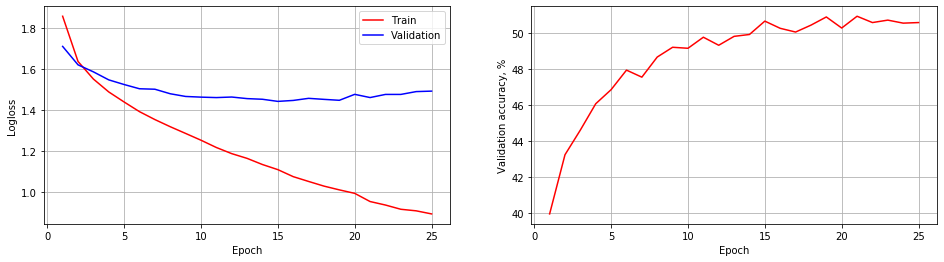

In [13]:
fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_tr, color='red', label='Train')
axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_val, color='blue', label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Logloss')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(np.arange(1, len(loss_tr) + 1), 100*np.array(acc_val), color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Validation accuracy, %')
axs[1].grid(True)

Yep, classical overfitting here. The graph says that we even hit more that $51\%$ accuracy somewhere around epoch 15, but then things got worse. We need more regularization.

## Model 3. Additional hidden layer + dropout.

Another cool regularization technique is dropout. We apply this, but also complicate model a little - by inserting another fully connected layer.

In [14]:
model3 = models.SequentialModel(
    layers=[
        layers.DenseLayer('FC1', features_in=3*32*32, features_out=512, include_bias=True, 
                          reg_coef=1e-2), 
        layers.BatchNorm('BN1'), 
        layers.ReLU('ReLU1'), 
        layers.Dropout('Drop1', p_drop=0.2), 
        layers.DenseLayer('FC2', features_in=512, features_out=128, include_bias=True, 
                          reg_coef=1e-2), 
        layers.BatchNorm('BN2'), 
        layers.ReLU('ReLU2'), 
        layers.Dropout('Drop2', p_drop=0.2), 
        layers.DenseLayer('FC3', features_in=128, features_out=len(labels), include_bias=True, 
                          reg_coef=1e-2)
    ]
)

Ok, checking on raw data.

In [15]:
pred0, _, loss0, _ = model3.predict(X_train_norm, y_train0)
print('Loss on training set : {0:.3f}'.format(loss0))
print('Accuracy on training set: {0:.2f}%'.format(100*accuracy(y_train0, pred0)))

Loss on training set : 2.635
Accuracy on training set: 11.07%


Something must be really off with initialization. Initial loss again is higher noticeably.

On to training.

In [16]:
loss_tr, loss_val, acc_val = models.train_SGD(model3, models.softmax_predict, 
    X_train_norm[train_idxs], y_train0[train_idxs], X_train_norm[val_idxs], y_train0[val_idxs], 
    metric=accuracy, 
    lr=1e-2, epochs=25, 
    lr_decrease_coef=0.5, lr_decrease_step=5, momentum=0.5, 
    batch_size=128, show_progress=True, verbose=True)


--------------------------------

Epoch 1/25...
Learning rate: 0.01


Epoch is over. Training loss: 2.016608452843626
Validation loss: 1.7657079238856017
Validation metric: 0.37832

--------------------------------

Epoch 2/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.7949751524139184
Validation loss: 1.6672752371087507
Validation metric: 0.41304

--------------------------------

Epoch 3/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.7055041063047385
Validation loss: 1.6082726077807288
Validation metric: 0.43504

--------------------------------

Epoch 4/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.640861184175731
Validation loss: 1.564127889261129
Validation metric: 0.4504

--------------------------------

Epoch 5/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.5910136810487978
Validation loss: 1.5313855438432857
Validation metric: 0.46448

--------------------------------

Epoch 6/25...
Learning rate: 0.005


Epoch is over. Training loss: 1.540303568329499
Validation loss: 1.5074261544714125
Validation metric: 0.4748

--------------------------------

Epoch 7/25...
Learning rate: 0.005


Epoch is over. Training loss: 1.5102850732891437
Validation loss: 1.4891338304188586
Validation metric: 0.482

--------------------------------

Epoch 8/25...
Learning rate: 0.005


Epoch is over. Training loss: 1.4864733749443826
Validation loss: 1.4721615059713027
Validation metric: 0.48536

--------------------------------

Epoch 9/25...
Learning rate: 0.005


Epoch is over. Training loss: 1.4587002059869307
Validation loss: 1.459452841326655
Validation metric: 0.49176

--------------------------------

Epoch 10/25...
Learning rate: 0.005


Epoch is over. Training loss: 1.4334486976366234
Validation loss: 1.4468925554852974
Validation metric: 0.48976

--------------------------------

Epoch 11/25...
Learning rate: 0.0025


Epoch is over. Training loss: 1.4073368089912366
Validation loss: 1.434251717683085
Validation metric: 0.498

--------------------------------

Epoch 12/25...
Learning rate: 0.0025


Epoch is over. Training loss: 1.3889284642200679
Validation loss: 1.4265870965726695
Validation metric: 0.50112

--------------------------------

Epoch 13/25...
Learning rate: 0.0025


Epoch is over. Training loss: 1.3753967305289923
Validation loss: 1.420692976863091
Validation metric: 0.5016

--------------------------------

Epoch 14/25...
Learning rate: 0.0025


Epoch is over. Training loss: 1.363145317290772
Validation loss: 1.41512723401943
Validation metric: 0.50224

--------------------------------

Epoch 15/25...
Learning rate: 0.0025


Epoch is over. Training loss: 1.35106317894226
Validation loss: 1.4065713874500942
Validation metric: 0.50184

--------------------------------

Epoch 16/25...
Learning rate: 0.00125


Epoch is over. Training loss: 1.329799721050773
Validation loss: 1.4027857289014058
Validation metric: 0.50376

--------------------------------

Epoch 17/25...
Learning rate: 0.00125


Epoch is over. Training loss: 1.3192921980099899
Validation loss: 1.4015478661370162
Validation metric: 0.50528

--------------------------------

Epoch 18/25...
Learning rate: 0.00125


Epoch is over. Training loss: 1.3088382049200544
Validation loss: 1.3984480889325408
Validation metric: 0.50512

--------------------------------

Epoch 19/25...
Learning rate: 0.00125


Epoch is over. Training loss: 1.3009235024854522
Validation loss: 1.394856452917641
Validation metric: 0.50688

--------------------------------

Epoch 20/25...
Learning rate: 0.00125


Epoch is over. Training loss: 1.2973341633830728
Validation loss: 1.3934769524328747
Validation metric: 0.50664

--------------------------------

Epoch 21/25...
Learning rate: 0.000625


Epoch is over. Training loss: 1.2876014158316444
Validation loss: 1.3909754861948382
Validation metric: 0.50864

--------------------------------

Epoch 22/25...
Learning rate: 0.000625


Epoch is over. Training loss: 1.2833618200442163
Validation loss: 1.3880125876007936
Validation metric: 0.50912

--------------------------------

Epoch 23/25...
Learning rate: 0.000625


Epoch is over. Training loss: 1.2809903842008283
Validation loss: 1.387352955230195
Validation metric: 0.51088

--------------------------------

Epoch 24/25...
Learning rate: 0.000625


Epoch is over. Training loss: 1.2719603677273923
Validation loss: 1.3867318609994312
Validation metric: 0.51048

--------------------------------

Epoch 25/25...
Learning rate: 0.000625


Epoch is over. Training loss: 1.2725808406974537
Validation loss: 1.3859936199058622
Validation metric: 0.5112

--------------------------------



Dropout is working - our model is more powerful than previous one, yet overfitting here is much less severe (if there is any). Let's examine training history.

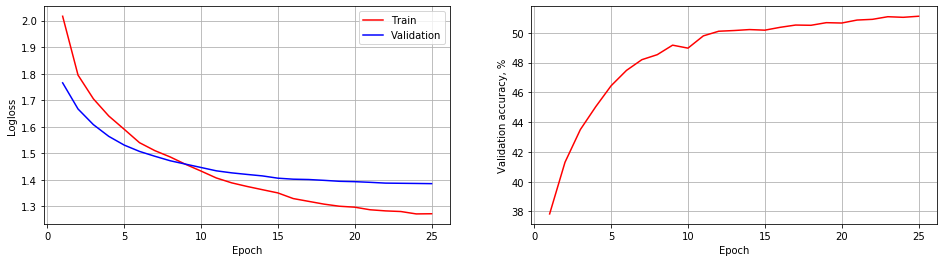

In [17]:
fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_tr, color='red', label='Train')
axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_val, color='blue', label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Logloss')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(np.arange(1, len(loss_tr) + 1), 100*np.array(acc_val), color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Validation accuracy, %')
axs[1].grid(True)

Looks good with $51.1\%$ accuracy on validation set. However, the gap between training and validation losses is still high. Yet, I fear that if I continue training the overfitting will kick in. Let's increase dropout probability.

## Model 4.

Same model as before, just higher dropout rate.

In [18]:
model4 = models.SequentialModel(
    layers=[
        layers.DenseLayer('FC1', features_in=3*32*32, features_out=512, include_bias=False, 
                          reg_coef=1e-2), 
        layers.BatchNorm('BN1'), 
        layers.ReLU('ReLU1'), 
        layers.Dropout('Drop1', p_drop=0.4), 
        layers.DenseLayer('FC2', features_in=512, features_out=128, include_bias=False, 
                          reg_coef=1e-2), 
        layers.BatchNorm('BN2'), 
        layers.ReLU('ReLU2'), 
        layers.Dropout('Drop2', p_drop=0.4), 
        layers.DenseLayer('FC3', features_in=128, features_out=len(labels), include_bias=True, 
                          reg_coef=1e-2)
    ]
)

Checking initial loss.

In [19]:
pred0, _, loss0, _ = model4.predict(X_train_norm, y_train0)
print('Loss on training set : {0:.3f}'.format(loss0))
print('Accuracy on training set: {0:.2f}%'.format(100*accuracy(y_train0, pred0)))

Loss on training set : 2.797
Accuracy on training set: 11.16%


Same story. However, accuracy is close to perfect.

In [20]:
loss_tr, loss_val, acc_val = models.train_SGD(model4, models.softmax_predict, 
    X_train_norm[train_idxs], y_train0[train_idxs], X_train_norm[val_idxs], y_train0[val_idxs], 
    metric=accuracy, 
    lr=1e-2, epochs=25, 
    lr_decrease_coef=0.75, lr_decrease_step=5, momentum=0.5, 
    batch_size=128, show_progress=True, verbose=True)


--------------------------------

Epoch 1/25...
Learning rate: 0.01


Epoch is over. Training loss: 2.129982748342616
Validation loss: 1.8480420089774259
Validation metric: 0.3516

--------------------------------

Epoch 2/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.9228872810492998
Validation loss: 1.7408834869717336
Validation metric: 0.38968

--------------------------------

Epoch 3/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.8363272968345603
Validation loss: 1.6808085880117078
Validation metric: 0.40792

--------------------------------

Epoch 4/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.7776344866415947
Validation loss: 1.6332441858325317
Validation metric: 0.42272

--------------------------------

Epoch 5/25...
Learning rate: 0.01


Epoch is over. Training loss: 1.7287156373208759
Validation loss: 1.5973769523922283
Validation metric: 0.43592

--------------------------------

Epoch 6/25...
Learning rate: 0.0075


Epoch is over. Training loss: 1.6962824686897464
Validation loss: 1.572403394604165
Validation metric: 0.44576

--------------------------------

Epoch 7/25...
Learning rate: 0.0075


Epoch is over. Training loss: 1.6699311936892474
Validation loss: 1.549884466865731
Validation metric: 0.45544

--------------------------------

Epoch 8/25...
Learning rate: 0.0075


Epoch is over. Training loss: 1.6360955272031885
Validation loss: 1.5322586060853756
Validation metric: 0.46288

--------------------------------

Epoch 9/25...
Learning rate: 0.0075


Epoch is over. Training loss: 1.6114339044429347
Validation loss: 1.508895615293273
Validation metric: 0.4696

--------------------------------

Epoch 10/25...
Learning rate: 0.0075


Epoch is over. Training loss: 1.5840325942965126
Validation loss: 1.4927142797086819
Validation metric: 0.47416

--------------------------------

Epoch 11/25...
Learning rate: 0.005625


Epoch is over. Training loss: 1.5566225454547868
Validation loss: 1.4779753837758942
Validation metric: 0.47912

--------------------------------

Epoch 12/25...
Learning rate: 0.005625


Epoch is over. Training loss: 1.5396783589755865
Validation loss: 1.464290452174061
Validation metric: 0.48184

--------------------------------

Epoch 13/25...
Learning rate: 0.005625


Epoch is over. Training loss: 1.519502818417878
Validation loss: 1.4499782518556612
Validation metric: 0.48712

--------------------------------

Epoch 14/25...
Learning rate: 0.005625


Epoch is over. Training loss: 1.5023571429994442
Validation loss: 1.4363001106762203
Validation metric: 0.49656

--------------------------------

Epoch 15/25...
Learning rate: 0.005625


Epoch is over. Training loss: 1.4872800232083436
Validation loss: 1.4275164512613652
Validation metric: 0.49544

--------------------------------

Epoch 16/25...
Learning rate: 0.00421875


Epoch is over. Training loss: 1.4644603961245097
Validation loss: 1.4199149648248184
Validation metric: 0.49672

--------------------------------

Epoch 17/25...
Learning rate: 0.00421875


Epoch is over. Training loss: 1.4461494280787608
Validation loss: 1.408996969338281
Validation metric: 0.50624

--------------------------------

Epoch 18/25...
Learning rate: 0.00421875


Epoch is over. Training loss: 1.4353189080594186
Validation loss: 1.403759325032801
Validation metric: 0.50568

--------------------------------

Epoch 19/25...
Learning rate: 0.00421875


Epoch is over. Training loss: 1.422374354052213
Validation loss: 1.39408095568505
Validation metric: 0.50952

--------------------------------

Epoch 20/25...
Learning rate: 0.00421875


Epoch is over. Training loss: 1.4062117652831747
Validation loss: 1.3837484477701474
Validation metric: 0.51072

--------------------------------

Epoch 21/25...
Learning rate: 0.0031640625


Epoch is over. Training loss: 1.386450482987917
Validation loss: 1.3790587730766213
Validation metric: 0.51464

--------------------------------

Epoch 22/25...
Learning rate: 0.0031640625


Epoch is over. Training loss: 1.3774144441396194
Validation loss: 1.3717684232831397
Validation metric: 0.51808

--------------------------------

Epoch 23/25...
Learning rate: 0.0031640625


Epoch is over. Training loss: 1.362854224380724
Validation loss: 1.3691454712045996
Validation metric: 0.51664

--------------------------------

Epoch 24/25...
Learning rate: 0.0031640625


Epoch is over. Training loss: 1.3512748684061957
Validation loss: 1.361158103074292
Validation metric: 0.52024

--------------------------------

Epoch 25/25...
Learning rate: 0.0031640625


Epoch is over. Training loss: 1.342495391067196
Validation loss: 1.3549268136389103
Validation metric: 0.5236

--------------------------------



Hmm, score on validation set in more that $1\%$ higher than before. Let's peek on graphs.

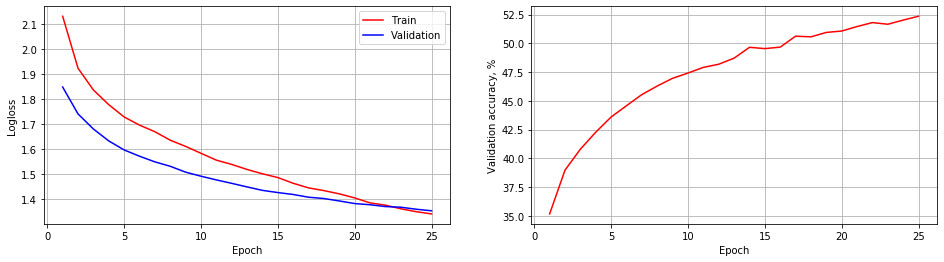

In [21]:
fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_tr, color='red', label='Train')
axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_val, color='blue', label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Logloss')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(np.arange(1, len(loss_tr) + 1), 100*np.array(acc_val), color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Validation accuracy, %')
axs[1].grid(True)

I believe there is still much potential. Both losses are still going down. I say we must continue training.

In [22]:
loss_tr2, loss_val2, acc_val2 = models.train_SGD(model4, models.softmax_predict, 
    X_train_norm[train_idxs], y_train0[train_idxs], X_train_norm[val_idxs], y_train0[val_idxs], 
    metric=accuracy, 
    lr=2e-3, epochs=25, 
    lr_decrease_coef=0.95, lr_decrease_step=1, momentum=0.5, 
    batch_size=128, show_progress=True, verbose=True)


--------------------------------

Epoch 1/25...
Learning rate: 0.002


Epoch is over. Training loss: 1.3195056676646169
Validation loss: 1.3530036869849613
Validation metric: 0.5216

--------------------------------

Epoch 2/25...
Learning rate: 0.0019


Epoch is over. Training loss: 1.3097820953698318
Validation loss: 1.3471290875114552
Validation metric: 0.52424

--------------------------------

Epoch 3/25...
Learning rate: 0.001805


Epoch is over. Training loss: 1.3016499996330573
Validation loss: 1.3447271385653143
Validation metric: 0.52408

--------------------------------

Epoch 4/25...
Learning rate: 0.00171475


Epoch is over. Training loss: 1.2850107405887958
Validation loss: 1.3422608457774332
Validation metric: 0.52792

--------------------------------

Epoch 5/25...
Learning rate: 0.0016290124999999997


Epoch is over. Training loss: 1.2812881526251951
Validation loss: 1.3381412638337322
Validation metric: 0.52736

--------------------------------

Epoch 6/25...
Learning rate: 0.0015475618749999996


Epoch is over. Training loss: 1.2748770110250993
Validation loss: 1.3390635040178738
Validation metric: 0.52736

--------------------------------

Epoch 7/25...
Learning rate: 0.0014701837812499995


Epoch is over. Training loss: 1.2649278890902547
Validation loss: 1.3340185694932656
Validation metric: 0.53104

--------------------------------

Epoch 8/25...
Learning rate: 0.0013966745921874994


Epoch is over. Training loss: 1.2591901320480734
Validation loss: 1.3362333348616007
Validation metric: 0.52936

--------------------------------

Epoch 9/25...
Learning rate: 0.0013268408625781243


Epoch is over. Training loss: 1.2555880906531312
Validation loss: 1.3331907703353225
Validation metric: 0.5292

--------------------------------

Epoch 10/25...
Learning rate: 0.001260498819449218


Epoch is over. Training loss: 1.242743002563505
Validation loss: 1.3325025997457356
Validation metric: 0.53136

--------------------------------

Epoch 11/25...
Learning rate: 0.001197473878476757


Epoch is over. Training loss: 1.2383130912276903
Validation loss: 1.329767413726811
Validation metric: 0.53264

--------------------------------

Epoch 12/25...
Learning rate: 0.001137600184552919


Epoch is over. Training loss: 1.2308962018081528
Validation loss: 1.3296121949767576
Validation metric: 0.53288

--------------------------------

Epoch 13/25...
Learning rate: 0.001080720175325273


Epoch is over. Training loss: 1.2270500206860633
Validation loss: 1.3266079989254416
Validation metric: 0.5328

--------------------------------

Epoch 14/25...
Learning rate: 0.0010266841665590094


Epoch is over. Training loss: 1.216392361775453
Validation loss: 1.3263969762100716
Validation metric: 0.53416

--------------------------------

Epoch 15/25...
Learning rate: 0.0009753499582310589


Epoch is over. Training loss: 1.2104578058540765
Validation loss: 1.3262223150751316
Validation metric: 0.53432

--------------------------------

Epoch 16/25...
Learning rate: 0.0009265824603195059


Epoch is over. Training loss: 1.205659543023493
Validation loss: 1.3244796410956796
Validation metric: 0.534

--------------------------------

Epoch 17/25...
Learning rate: 0.0008802533373035306


Epoch is over. Training loss: 1.2001936632350552
Validation loss: 1.327451847249442
Validation metric: 0.53512

--------------------------------

Epoch 18/25...
Learning rate: 0.0008362406704383541


Epoch is over. Training loss: 1.1943235934671799
Validation loss: 1.3243305682393944
Validation metric: 0.53704

--------------------------------

Epoch 19/25...
Learning rate: 0.0007944286369164363


Epoch is over. Training loss: 1.191018253354837
Validation loss: 1.323988498649314
Validation metric: 0.53632

--------------------------------

Epoch 20/25...
Learning rate: 0.0007547072050706144


Epoch is over. Training loss: 1.1868601680199715
Validation loss: 1.3222125449494266
Validation metric: 0.53504

--------------------------------

Epoch 21/25...
Learning rate: 0.0007169718448170836


Epoch is over. Training loss: 1.176385586261313
Validation loss: 1.3201147845775396
Validation metric: 0.53672

--------------------------------

Epoch 22/25...
Learning rate: 0.0006811232525762294


Epoch is over. Training loss: 1.1780889884864756
Validation loss: 1.3208757604065775
Validation metric: 0.53696

--------------------------------

Epoch 23/25...
Learning rate: 0.0006470670899474179


Epoch is over. Training loss: 1.1760689240300601
Validation loss: 1.31897151523716
Validation metric: 0.53728

--------------------------------

Epoch 24/25...
Learning rate: 0.0006147137354500469


Epoch is over. Training loss: 1.1664767451335298
Validation loss: 1.3204599073802448
Validation metric: 0.53728

--------------------------------

Epoch 25/25...
Learning rate: 0.0005839780486775445


Epoch is over. Training loss: 1.1628845782580592
Validation loss: 1.3194137015216396
Validation metric: 0.53888

--------------------------------



And we reach $53.9\%$ accuracy!

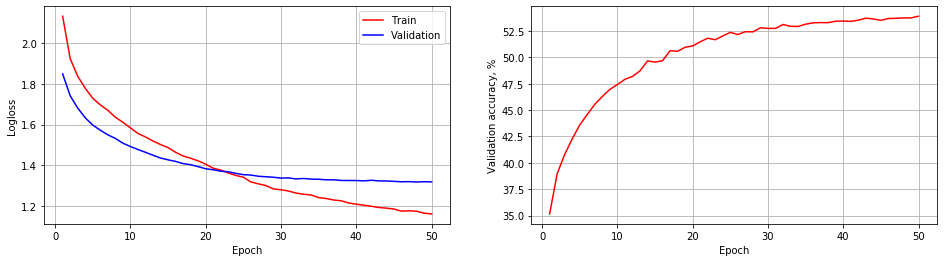

In [23]:
loss_tr += loss_tr2
loss_val += loss_val2
acc_val += acc_val2

fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_tr, color='red', label='Train')
axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_val, color='blue', label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Logloss')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(np.arange(1, len(loss_tr) + 1), 100*np.array(acc_val), color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Validation accuracy, %')
axs[1].grid(True)

That seems to be the limit of this model. A bit more - and it will start overfitting.

Time to compare our models' performances on test set.

In [34]:
print('Model 1 accuracy on test set: {0:.2f}%'.format(100*accuracy(
    y_test0, model1.predict(X_test0)[0])))
print('Model 2 accuracy on test set: {0:.2f}%'.format(100*accuracy(
    y_test0, model2.predict(X_test_norm)[0])))
print('Model 3 accuracy on test set: {0:.2f}%'.format(100*accuracy(
    y_test0, model3.predict(X_test_norm)[0])))
print('Model 4 accuracy on test set: {0:.2f}%'.format(100*accuracy(
    y_test0, model4.predict(X_test_norm)[0])))

Model 1 accuracy on test set: 43.20%
Model 2 accuracy on test set: 50.21%
Model 3 accuracy on test set: 51.37%
Model 4 accuracy on test set: 53.91%


And the winner is model 4 with $53.9\%$ accuracy. 

## Checking with Torch

Let's check our results with PyTorch. We implement same model (almost).

Since there is CUDA-compatible GPU on my computer, I'll use it for training.

In [25]:
assert torch.cuda.is_available()
GPU = torch.device('cuda: 0')

All we have to do to implement our own dataset is to inherit from PyTorch `Dataset` class and overwrite two methods.

In [26]:
class CIFAR10(Dataset):
    def __init__(self, X, y,):
        super().__init__()
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ix):
        return (torch.from_numpy(self.X[ix]).float(), self.y[ix])

Prepare data loaders.

In [27]:
train_dset = CIFAR10(X_train_norm, y_train0)
test_dset = CIFAR10(X_test_norm, y_test0)

train_loader = DataLoader(train_dset, batch_size=128, 
                          sampler=SubsetRandomSampler(indices=train_idxs))
val_loader = DataLoader(train_dset, batch_size=128, 
                        sampler=SubsetRandomSampler(indices=val_idxs))
test_loader = DataLoader(test_dset, batch_size=128, 
                         sampler=SubsetRandomSampler(indices=np.arange(len(test_dset))))

Building model with same architecture.

**NOTE**: There is one difference: `BatchNorm1d` from PyTorch here will normalize every column of data matrix separately (so for first FC layer it will have 512 means and stds), while my implementation has only one common mean and std. 

In [28]:
model_torch = nn.Sequential(
    nn.Linear(in_features=3*32*32, out_features=512, bias=False), 
    nn.BatchNorm1d(num_features=512), 
    nn.Dropout(p=0.4), 
    nn.ReLU(), 
    nn.Linear(in_features=512, out_features=128, bias=False), 
    nn.BatchNorm1d(num_features=128), 
    nn.Dropout(p=0.4), 
    nn.ReLU(), 
    nn.Linear(in_features=128, out_features=len(labels), bias=True)
)

Moving model to GPU.

In [29]:
model_torch.type(torch.cuda.FloatTensor)
model_torch.to(GPU)

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=False)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.4)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=128, bias=False)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.4)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=10, bias=True)
)

Let's check how PyTorch model initializes.

In [30]:
predX, gt = predict_torch(model_torch, train_loader, GPU)
loss = torch.nn.CrossEntropyLoss()(predX, gt).item()

print('Torch model loss on validation set: {0:.3f}'.format(loss))
print('Torch model accuracy on validation set: {0:.2f}%'.format(
    100*accuracy(gt.detach().cpu().numpy(), predX.detach().cpu().numpy().argmax(axis=1))))

Torch model loss on validation set: 2.306
Torch model accuracy on validation set: 9.63%


Indeed I have to revisit my initialization strategy. This one is close to perfect.

All right. Initialize all the necessary components and get on with training. We will train for 40 epochs.

In [31]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model_torch.parameters(), lr=1e-2, momentum=0.9)
lr_sch = torch.optim.lr_scheduler.StepLR(opt, gamma=0.75, step_size=5)

loss_tr, loss_val, acc_val = train_torch(model_torch, GPU, train_loader, val_loader, 
                                         loss_fct, opt, lr_sch, accuracy, 
                                         num_epochs=40, verbose=True, show_progress=True)

--------------------------------
Epoch 1/40
--------------------------------


Training pass over. Loss: 1.8468920308303833
Validation loss: 1.62297785282135
Validation metric: 0.41976


--------------------------------
Epoch 2/40
--------------------------------


Training pass over. Loss: 1.6558747465133667
Validation loss: 1.5147912502288818
Validation metric: 0.45928


--------------------------------
Epoch 3/40
--------------------------------


Training pass over. Loss: 1.5826847553888956
Validation loss: 1.4670456647872925
Validation metric: 0.47512


--------------------------------
Epoch 4/40
--------------------------------


Training pass over. Loss: 1.530560911916097
Validation loss: 1.4301140308380127
Validation metric: 0.48464


--------------------------------
Epoch 5/40
--------------------------------


Training pass over. Loss: 1.4906798268000285
Validation loss: 1.3941396474838257
Validation metric: 0.49512


--------------------------------
Epoch 6/40
--------------------------------


Training pass over. Loss: 1.443823466237386
Validation loss: 1.365476369857788
Validation metric: 0.50896


--------------------------------
Epoch 7/40
--------------------------------


Training pass over. Loss: 1.4136165466308594
Validation loss: 1.3491376638412476
Validation metric: 0.51384


--------------------------------
Epoch 8/40
--------------------------------


Training pass over. Loss: 1.3915937317530314
Validation loss: 1.3364171981811523
Validation metric: 0.52112


--------------------------------
Epoch 9/40
--------------------------------


Training pass over. Loss: 1.371985866317749
Validation loss: 1.3363176584243774
Validation metric: 0.51904


--------------------------------
Epoch 10/40
--------------------------------


Training pass over. Loss: 1.3505142628351847
Validation loss: 1.31770658493042
Validation metric: 0.52096


--------------------------------
Epoch 11/40
--------------------------------


Training pass over. Loss: 1.3199407639058431
Validation loss: 1.296942949295044
Validation metric: 0.52976


--------------------------------
Epoch 12/40
--------------------------------


Training pass over. Loss: 1.298340430577596
Validation loss: 1.2904115915298462
Validation metric: 0.53472


--------------------------------
Epoch 13/40
--------------------------------


Training pass over. Loss: 1.2849341098276774
Validation loss: 1.3000577688217163
Validation metric: 0.53336


--------------------------------
Epoch 14/40
--------------------------------


Training pass over. Loss: 1.2664741392771404
Validation loss: 1.272944688796997
Validation metric: 0.54176


--------------------------------
Epoch 15/40
--------------------------------


Training pass over. Loss: 1.2592490491231283
Validation loss: 1.2742457389831543
Validation metric: 0.54608


--------------------------------
Epoch 16/40
--------------------------------


Training pass over. Loss: 1.2267775867970785
Validation loss: 1.2578234672546387
Validation metric: 0.55088


--------------------------------
Epoch 17/40
--------------------------------


Training pass over. Loss: 1.2098106645584106
Validation loss: 1.2652989625930786
Validation metric: 0.54384


--------------------------------
Epoch 18/40
--------------------------------


Training pass over. Loss: 1.2033914464823405
Validation loss: 1.2477346658706665
Validation metric: 0.5516


--------------------------------
Epoch 19/40
--------------------------------


Training pass over. Loss: 1.1931280965550741
Validation loss: 1.2519387006759644
Validation metric: 0.55176


--------------------------------
Epoch 20/40
--------------------------------


Training pass over. Loss: 1.1789647924168905
Validation loss: 1.2484536170959473
Validation metric: 0.55272


--------------------------------
Epoch 21/40
--------------------------------


Training pass over. Loss: 1.1554096458816527
Validation loss: 1.2364904880523682
Validation metric: 0.55656


--------------------------------
Epoch 22/40
--------------------------------


Training pass over. Loss: 1.1360068904622396
Validation loss: 1.241294503211975
Validation metric: 0.55568


--------------------------------
Epoch 23/40
--------------------------------


Training pass over. Loss: 1.1349964819081624
Validation loss: 1.2365697622299194
Validation metric: 0.55624


--------------------------------
Epoch 24/40
--------------------------------


Training pass over. Loss: 1.1222949213155111
Validation loss: 1.2307379245758057
Validation metric: 0.55808


--------------------------------
Epoch 25/40
--------------------------------


Training pass over. Loss: 1.1118580653508505
Validation loss: 1.2378261089324951
Validation metric: 0.55824


--------------------------------
Epoch 26/40
--------------------------------


Training pass over. Loss: 1.0872452634557088
Validation loss: 1.2247897386550903
Validation metric: 0.56176


--------------------------------
Epoch 27/40
--------------------------------


Training pass over. Loss: 1.0766279636383056
Validation loss: 1.2304577827453613
Validation metric: 0.56224


--------------------------------
Epoch 28/40
--------------------------------


Training pass over. Loss: 1.0658661423110962
Validation loss: 1.2280181646347046
Validation metric: 0.56768


--------------------------------
Epoch 29/40
--------------------------------


Training pass over. Loss: 1.058558955930074
Validation loss: 1.226654052734375
Validation metric: 0.56224


--------------------------------
Epoch 30/40
--------------------------------


Training pass over. Loss: 1.0509261541875203
Validation loss: 1.2336184978485107
Validation metric: 0.56056


--------------------------------
Epoch 31/40
--------------------------------


Training pass over. Loss: 1.0366947724787394
Validation loss: 1.220973253250122
Validation metric: 0.56808


--------------------------------
Epoch 32/40
--------------------------------


Training pass over. Loss: 1.0295290811920166
Validation loss: 1.2338123321533203
Validation metric: 0.56256


--------------------------------
Epoch 33/40
--------------------------------


Training pass over. Loss: 1.0153301962534587
Validation loss: 1.223584771156311
Validation metric: 0.56448


--------------------------------
Epoch 34/40
--------------------------------


Training pass over. Loss: 1.0026734324900308
Validation loss: 1.23316490650177
Validation metric: 0.56552


--------------------------------
Epoch 35/40
--------------------------------


Training pass over. Loss: 0.996559251759847
Validation loss: 1.2276690006256104
Validation metric: 0.56648


--------------------------------
Epoch 36/40
--------------------------------


Training pass over. Loss: 0.982192688700358
Validation loss: 1.2218581438064575
Validation metric: 0.566


--------------------------------
Epoch 37/40
--------------------------------


Training pass over. Loss: 0.9701114912668863
Validation loss: 1.2247191667556763
Validation metric: 0.56376


--------------------------------
Epoch 38/40
--------------------------------


Training pass over. Loss: 0.967840762462616
Validation loss: 1.220644474029541
Validation metric: 0.56464


--------------------------------
Epoch 39/40
--------------------------------


Training pass over. Loss: 0.9682059662501017
Validation loss: 1.2227646112442017
Validation metric: 0.57208


--------------------------------
Epoch 40/40
--------------------------------


Training pass over. Loss: 0.950067075106303
Validation loss: 1.2328733205795288
Validation metric: 0.56344




Results are quite better. Let's see the graphs.

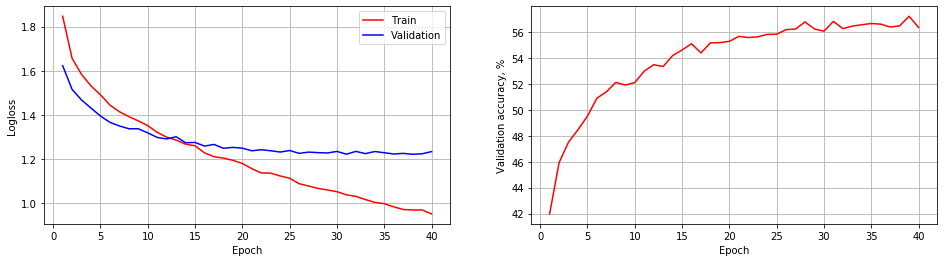

In [32]:
fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_tr, color='red', label='Train')
axs[0].plot(np.arange(1, len(loss_tr) + 1), loss_val, color='blue', label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Logloss')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(np.arange(1, len(loss_tr) + 1), 100*np.array(acc_val), color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Validation accuracy, %')
axs[1].grid(True)

We already started overfitting a little, so it's time to stop here. We got better results (not surprisingly) than those with my own implementation.

Let's see how it performed on test set.

In [33]:
predX, gt = predict_torch(model_torch, test_loader, GPU)

print('Torch model accuracy on validation set: {0:.2f}%'.format(
    100*accuracy(gt.detach().cpu().numpy(), predX.detach().cpu().numpy().argmax(axis=1))))

Torch model accuracy on validation set: 56.66%


That's $56.7\%$ accuracy with simplest network without any convolutions. Pretty neat.

**Conclusion**: PyTorch and my own results match pretty good, there is no surprise that PyTorch performs better and much faster. Particularly something seems to be off with initialization. Need to revisit it.